<a href="https://colab.research.google.com/github/aks2093/corona-Data-analysis-and-prediction/blob/master/timeSeries_model_recovered_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
import numpy as np

data_dir = "/content/drive/My Drive/vumonic"
latest = os.path.join(data_dir, "07-12-2020.csv")
confirmed = os.path.join(data_dir, "time_series_covid19_confirmed_global.csv")
deaths = os.path.join(data_dir, "time_series_covid19_deaths_global.csv")
recovered = os.path.join(data_dir, "time_series_covid19_recovered_global.csv")
csse_daily = os.path.join(data_dir, "csse_daily.csv")
population = os.path.join(data_dir, "population_by_country_2020.csv") #data source: https://www.kaggle.com/tanuprabhu/population-by-country-2020

latest = pd.read_csv(latest)
confirmed = pd.read_csv(confirmed)
deaths = pd.read_csv(deaths)
recovered = pd.read_csv(recovered)
csse_daily = pd.read_csv(csse_daily)
population = pd.read_csv(population)

print("Data Import Done")

Data Import Done


# Building a Time series model for confirmed cases

**Approach:**
1. Here we are trying to predict daily increase in the recovered cases.
2. will keep last 7 days for forecast
3. we will skip the timeline 22nd-Jan to 15th-Feb for all countries except china, and train our time series model on data starting from 16th Feb.

In [4]:
excluded_columns = ['Province/State', 'Lat', 'Long']


required_recovery_word_wide_data = recovered.drop(excluded_columns, axis=1)

country_wise_recovered_cases = required_recovery_word_wide_data.groupby(["Country/Region"]).sum().reset_index()

countries = country_wise_recovered_cases[["Country/Region"]]
countries["Country/Region"] = countries["Country/Region"].apply(lambda x:x.lower())

country_wise_recovered_cases = country_wise_recovered_cases.drop("Country/Region", axis=1)

daily_increase_in_recovered_cases = country_wise_recovered_cases.diff(axis = 1, periods = 1)
daily_increase_in_recovered_cases = daily_increase_in_recovered_cases.fillna(0)
daily_increase_in_recovered_cases = pd.concat([countries, daily_increase_in_recovered_cases], axis=1)
print(daily_increase_in_recovered_cases.columns)

Index(['Country/Region', '1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20',
       '1/27/20', '1/28/20', '1/29/20', '1/30/20',
       ...
       '7/4/20', '7/5/20', '7/6/20', '7/7/20', '7/8/20', '7/9/20', '7/10/20',
       '7/11/20', '7/12/20', '7/13/20'],
      dtype='object', length=175)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib import pyplot as plt

daily_increase_in_recovered_cases["Country/Region"] = daily_increase_in_recovered_cases["Country/Region"].apply(lambda x: x.lower())

#taking increment in confirmed cases after 15 Feb except "China" 
#exluding last 7 days for test forecasting
last_7_days_for_forecasting = daily_increase_in_recovered_cases.columns.to_list()[168:]
before_16_feb_columns = daily_increase_in_recovered_cases.columns.to_list()[1:26]
drop_columns =  before_16_feb_columns + last_7_days_for_forecasting

daily_increase_in_recovered_cases_after_16_feb = daily_increase_in_recovered_cases.drop(before_16_feb_columns, axis=1)
print(daily_increase_in_recovered_cases_after_16_feb.columns)

# result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

Index(['Country/Region', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       ...
       '7/4/20', '7/5/20', '7/6/20', '7/7/20', '7/8/20', '7/9/20', '7/10/20',
       '7/11/20', '7/12/20', '7/13/20'],
      dtype='object', length=150)


**Seasonal Decomposition of increment in recovered cases for china**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

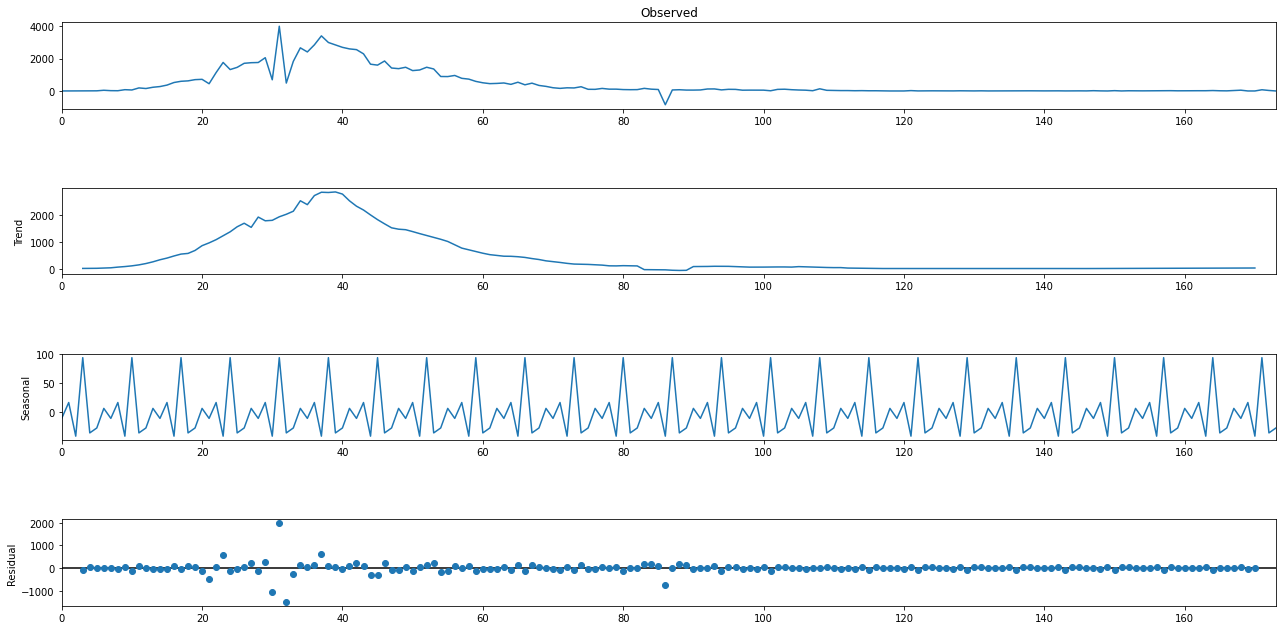

In [6]:
daily_increase_in_recovered_cases_china = daily_increase_in_recovered_cases[daily_increase_in_recovered_cases["Country/Region"]=="china"]
daily_increase_in_recovered_cases_china_values = daily_increase_in_recovered_cases_china.drop(daily_increase_in_recovered_cases_china.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_recovered_cases_china_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition of increment in recovered cases in USA**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

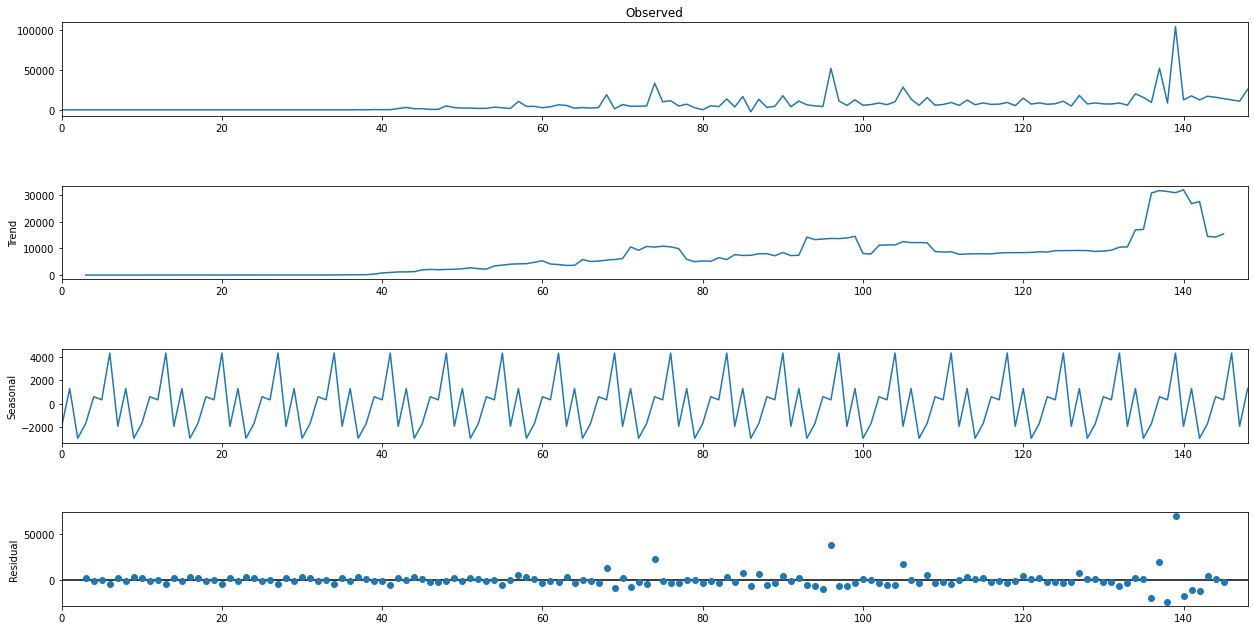

In [7]:
daily_increase_in_recovered_cases_usa = daily_increase_in_recovered_cases_after_16_feb[daily_increase_in_recovered_cases_after_16_feb["Country/Region"]=="us"]
daily_increase_in_recovered_cases_usa_values = daily_increase_in_recovered_cases_usa.drop(daily_increase_in_recovered_cases_usa.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_recovered_cases_usa_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition of increment in confirmed cases for India**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

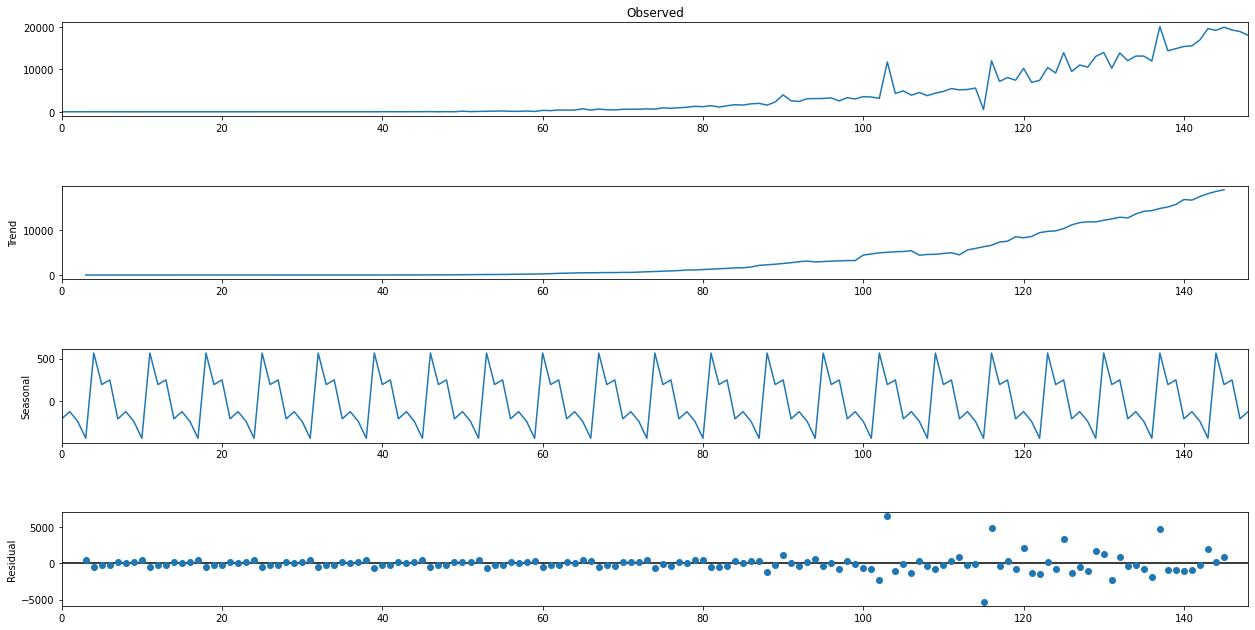

In [8]:
daily_increase_in_recovered_cases_india = daily_increase_in_recovered_cases_after_16_feb[daily_increase_in_recovered_cases_after_16_feb["Country/Region"]=="india"]
daily_increase_in_recovered_cases_india_values = daily_increase_in_recovered_cases_india.drop(daily_increase_in_recovered_cases_india.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_recovered_cases_india_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition of increment in recovered cases for Brazil**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

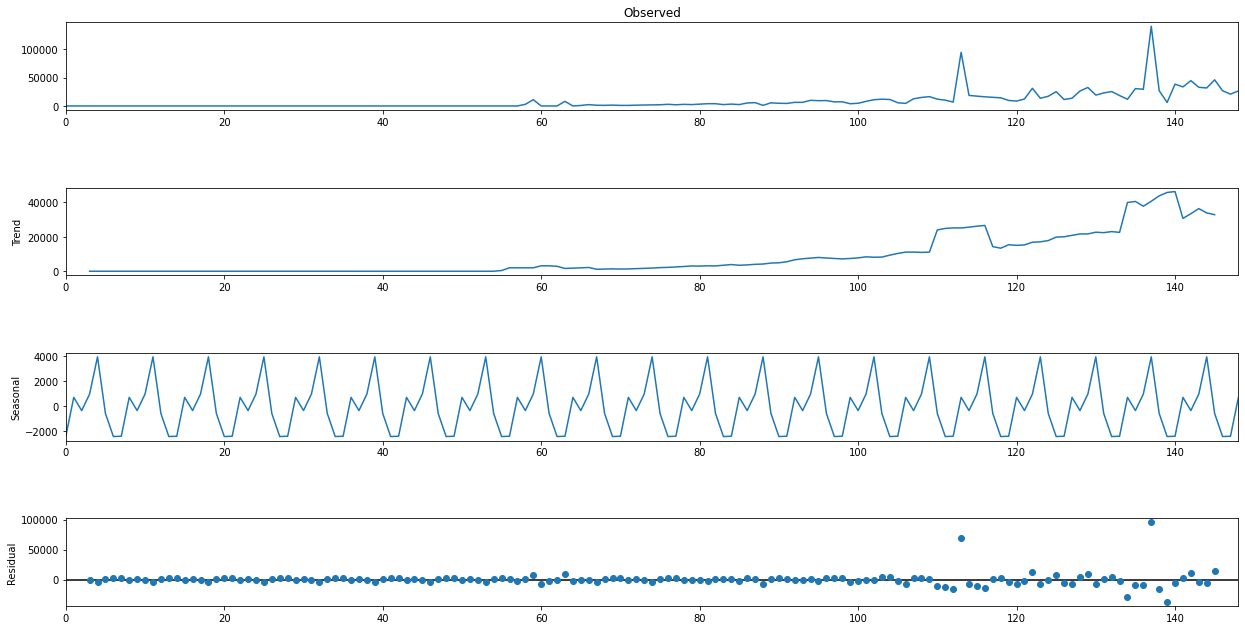

In [9]:
daily_increase_in_recovered_cases_brazil = daily_increase_in_recovered_cases_after_16_feb[daily_increase_in_recovered_cases_after_16_feb["Country/Region"]=="brazil"]
daily_increase_in_recovered_cases_brazil_values = daily_increase_in_recovered_cases_brazil.drop(daily_increase_in_recovered_cases_brazil.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_recovered_cases_brazil_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

# Building ARIMA model to predict increment in recovered cases country wise

In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.6MB/s 
     |████████████████████████████████| 8.7MB 45.8MB/s 
     |████████████████████████████████| 2.1MB 42.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [10]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

## 5.1 : Estimating the differencing term

country_model = {}
# print(countries)
for country in countries.values.ravel():
    print(country)
    data = daily_increase_in_recovered_cases[daily_increase_in_recovered_cases["Country/Region"]==country]
    data = data.drop(["Country/Region"]+last_7_days_for_forecasting, axis=1)
    if country!="china":
        data = data.drop(before_16_feb_columns, axis=1)
    data = data.values.ravel()
    kpss_diffs = ndiffs(data, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)

    model_auto = pm.auto_arima(data, start_p=1, start_q=1,
    #                     test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q 
                        m=1,              # frequency of series
                        d=n_diffs,        
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    country_model[country]=model_auto

afghanistan
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1954.942, BIC=1966.737, Time=0.217 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2030.295, BIC=2036.192, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2000.853, BIC=2009.699, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1953.230, BIC=1962.076, Time=0.119 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2028.332, BIC=2031.281, Time=0.010 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1954.724, BIC=1966.519, Time=0.218 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1944.659, BIC=1959.403, Time=0.224 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 0.835 seconds
albania
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=980.361, BIC

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1045.052, BIC=1056.847, Time=0.171 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1095.241, BIC=1101.139, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1075.517, BIC=1084.363, Time=0.042 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1043.297, BIC=1052.143, Time=0.050 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1093.280, BIC=1096.229, Time=0.014 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1044.831, BIC=1056.626, Time=0.075 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1045.289, BIC=1060.032, Time=0.145 seconds
Total fit time: 0.515 seconds
malawi
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1164.143, BIC=1175.938, Time=0.252 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1259.167, BIC=1265.064, Time=0.023 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1212.951, BIC=1221.798, Time=0.046 seconds

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/auto.py:328: UserWarning:

Input time-series is completely constant; returning a (0, 0, 0) ARMA.



Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1963.523, BIC=1975.318, Time=0.170 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2081.184, BIC=2087.081, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1991.218, BIC=2000.065, Time=0.028 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1982.226, BIC=1991.072, Time=0.127 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2079.184, BIC=2082.133, Time=0.009 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=1965.425, BIC=1980.169, Time=0.268 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1965.421, BIC=1980.165, Time=0.289 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1964.482, BIC=1976.277, Time=0.170 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=1972.090, BIC=1983.885, Time=0.042 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=1962.030, BIC=1979.722, Time=0.284 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=1963.726, BIC=1984.367, Time=0

**Predictions of increment in daily recovered cases**

In [17]:
prediction_countries = ["india"]
for country in prediction_countries:
    print("Predicted Increment in daily recovred cases in {} for next 7 days are: {}".format(country.upper(), country_model[country].predict(7, alpha=0.05).tolist()))

print("----------------------------------------------------------")
for country in prediction_countries:
    actual_increment = daily_increase_in_recovered_cases[daily_increase_in_recovered_cases["Country/Region"]==country].iloc[:,168:175].values.ravel().tolist()
    print("Actual Increment in daily recovred cases in {} for next 7 days are: {}".format(country.upper(), actual_increment))

Predicted Increment in daily recovred cases in INDIA for next 7 days are: [16005.72934689173, 15254.408827511743, 16425.989332609948, 15403.065608582223, 16661.241124882938, 15664.770398697818, 16801.81829081997]
----------------------------------------------------------
Actual Increment in daily recovred cases in INDIA for next 7 days are: [16897.0, 19547.0, 19135.0, 19873.0, 19232.0, 18853.0, 17989.0]


# Predicting the increment in recovered cases world_wide

**Algo:**

1. initialize world_total_recovered_cases = 0

2. for every country predict the increment in recovered cases

    >new_recovered_cases_for_the_country = increment in recovered cases + recovred cases on previous day for that country.

    >world_total_recovered_cases = world_total_recovered_cases + new_recovred_cases_for_the_country

# Future Steps/Improvements

Since We have inadequate data to predict the confirm cases

it would be better if we can have 
1. daily basis hospital data, 
2. daily basis lockdown period data,
3. daily basis people tracedown data
4. travel history data
5. Persons Health data